In [1]:
import time

import numpy as np
import matplotlib.pyplot as plt
from typing import List

# Configure plot defaults
plt.rcParams["axes.facecolor"] = "white"
plt.rcParams["grid.color"] = "#666666"

In [2]:
import pysr

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [3]:
import sympy
import numpy as np
from matplotlib import pyplot as plt
from pysr import PySRRegressor
from sklearn.model_selection import train_test_split

# Multi-fidelity using SRegression

In [4]:
# Here we take an example from adapt official website.
# example from https://adapt-python.github.io/adapt/examples/Multi_fidelity.html
def low_fidelity(Xs):
    ys = (1 - Xs**2) * np.sin(2 * 2 * np.pi * Xs) - Xs
    return ys


def high_fidelity(Xt):
    yt = (1 - Xt**2) * np.sin(2 * 2 * np.pi * Xt) - Xt - 1.5
    return yt

In [5]:
x_plot = np.linspace(0, 1, 200)[:, None]
y_plot_l = low_fidelity(x_plot)
y_plot_h = high_fidelity(x_plot)

x_train_l = x_plot
x_train_h = x_plot[:100]

# For low-fidelity training data, injecting some Gaussian noise.
y_train_l = low_fidelity(x_train_l) + 0.1 * np.random.randn(len(x_train_l))[:, None]
y_train_h = high_fidelity(x_train_h)

We usually have more HF training points than the LF training points.


In [6]:
y_train_h.shape, y_train_l.shape

((100, 1), (200, 1))

Text(0.5, 1.0, 'High and low fidelity functions')

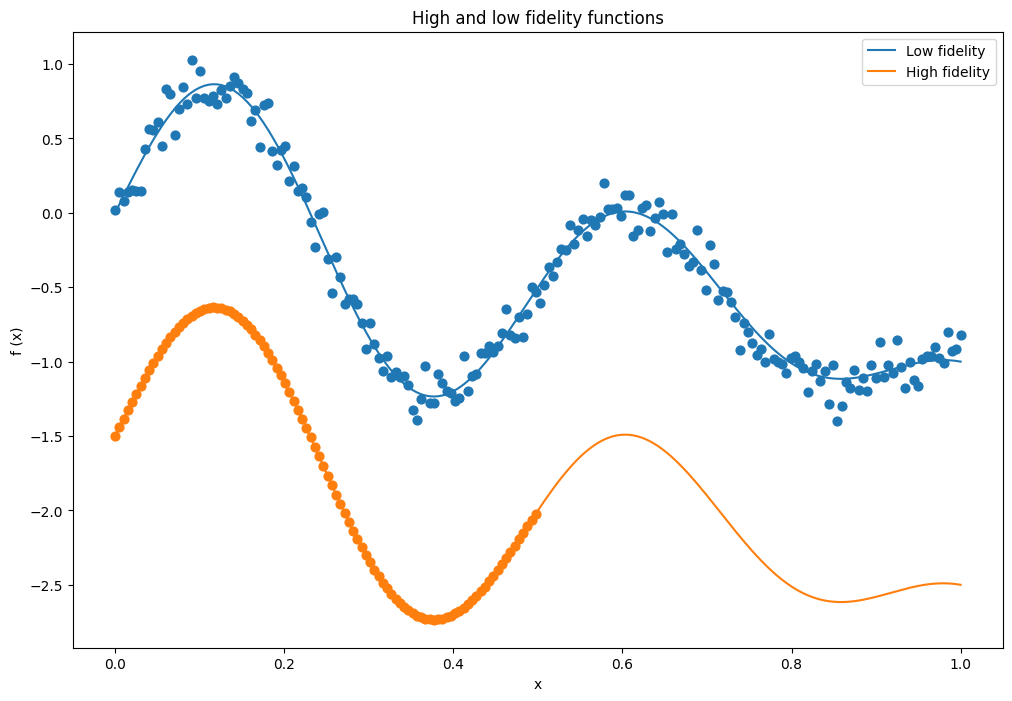

In [7]:
## Plot the original functions

plt.figure(figsize=(12, 8))
plt.plot(x_plot, y_plot_l, "C0")
plt.plot(x_plot, y_plot_h, "C1")
plt.scatter(x_train_l, y_train_l, color="C0", s=40)
plt.scatter(x_train_h, y_train_h, color="C1", s=40)
plt.ylabel("f (x)")
plt.xlabel("x")
plt.legend(["Low fidelity", "High fidelity"])
plt.title("High and low fidelity functions")

In [8]:
default_pysr_params = dict(
    populations=30,
    model_selection="best",
    denoise=True,
)

# Learn equations
model = PySRRegressor(
    niterations=30,
    binary_operators=["+", "*", "-"],
    unary_operators=["cos", "exp", "sin", "square", "cube", "log"],
    **default_pysr_params,
)

model.fit(x_train_l, y_train_l)

/Users/jibanmac/Documents/conda/emu-3.9/lib/python3.9/site-packages/pysr/sr.py:2582: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/Users/jibanmac/Documents/conda/emu-3.9/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Compiling Julia backend...


[ Info: Started!


PySRRegressor.equations_ = [
	    pick     score                                           equation  \
	0         0.000000                                         0.36729774   
	1         0.894129                                   sin(-0.43614185)   
	2         0.502010                                   0.077557966 - x0   
	3         0.000032                                1.2964958 - exp(x0)   
	4         0.083943                      (0.20158799 - x0) * 1.4031305   
	5         0.084752                         cube(0.83317685 - x0) - x0   
	6         0.973054                      sin(x0 * cube(2.343119)) - x0   
	7         1.178103                 sin(sin(x0 * cube(2.334562)) - x0)   
	8         0.192255           sin(sin(sin(x0 * cube(2.3335304))) - x0)   
	9         0.308872  sin(sin(x0 * square(3.5633833)) - x0) + -0.100...   
	10        1.976797    (sin(x0 * cube(2.334562)) * cube(cos(x0))) - x0   
	11        0.097961  (sin(x0 * cube(2.334562)) * square(cos(x0))) -...   
	12        0.248106  (cube(cos(sin(x0))) * sin(x0 * cube(2.334562))...   
	13        0.249826  (((1.013352 - square(x0)) * sin(x0 * cube(2.33...   
	14        0.255284  1.0365554 * ((cube(cos(sin(x0))) * sin(cube(2....   
	15        0.335052  ((square(cos(x0)) * sin(cube(2.3296075) * x0))...   
	16        0.122534  ((square(cos(x0)) * sin(cube(2.3296075) * x0))...   
	17        0.034531  ((square(cos(x0)) * sin(cube(2.3296075) * x0))...   
	18        0.106558  (cos(sin(cube(sin(x0)))) * ((square(cos(x0)) *...   
	19  >>>>  0.306324  cos(sin(sin(cube(sin(x0))))) * ((square(cos(x0...   
	
	        loss  complexity  
	0   1.055246           1  
	1   0.431557           2  
	2   0.261227           3  
	3   0.261219           4  
	4   0.240187           5  
	5   0.220669           6  
	6   0.083397           7  
	7   0.025675           8  
	8   0.021184           9  
	9   0.015555          10  
	10  0.002155          11  
	11  0.001953          12  
	12  0.001524          13  
	13  0.001187          14  
	14  0.000920          15  
	15  0.000658          16  
	16  0.000582          17  
	17  0.000562          18  
	18  0.000505          19  
	19  0.000372          20  
]

In [9]:
model.sympy()

(-x0 + sin(12.6429455470427*x0)*cos(x0 - 1*(-0.02563029))**2)*cos(sin(sin(sin(x0)**3)))

In [10]:
ypredict = model.predict(x_plot)
ypredict_simpler = model.predict(x_plot, 2)

print("Default selection MSE:", np.power(ypredict - y_plot_l, 2).mean())
print("Manual selection MSE for index 2:", np.power(ypredict_simpler - y_plot_l, 2).mean())

/Users/jibanmac/Documents/conda/emu-3.9/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/jibanmac/Documents/conda/emu-3.9/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Default selection MSE: 0.8534864077290988
Manual selection MSE for index 2: 0.5126124697492802


Text(0.5, 1.0, 'High and low fidelity functions')

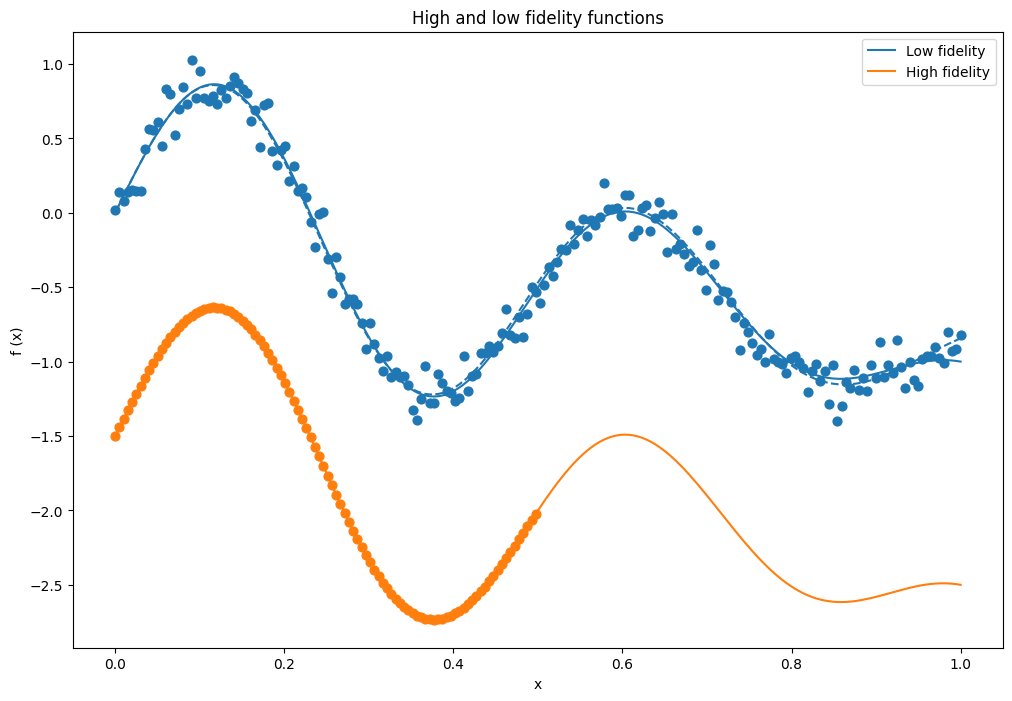

In [11]:
## Plot the original functions

plt.figure(figsize=(12, 8))
plt.plot(x_plot, y_plot_l, "C0")
plt.plot(x_plot, y_plot_h, "C1")
plt.plot(x_plot, ypredict, "C0--")
plt.scatter(x_train_l, y_train_l, color="C0", s=40)
plt.scatter(x_train_h, y_train_h, color="C1", s=40)
plt.ylabel("f (x)")
plt.xlabel("x")
plt.legend(["Low fidelity", "High fidelity"])
plt.title("High and low fidelity functions")

We can also filter all equations up to 2x the most accurate equation, then select the best score from that list:

In [12]:
best_idx = model.equations_.query(
    f"loss < {2 * model.equations_.loss.min()}"
).score.idxmax()
model.sympy(best_idx)

(-x0 + sin(12.6429455470427*x0)*cos(x0)**2)*cos(sin(x0)**3)

## Naive multi-fidelity

Train on HF data - LF model

/Users/jibanmac/Documents/conda/emu-3.9/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


(-2.5, 1.5)

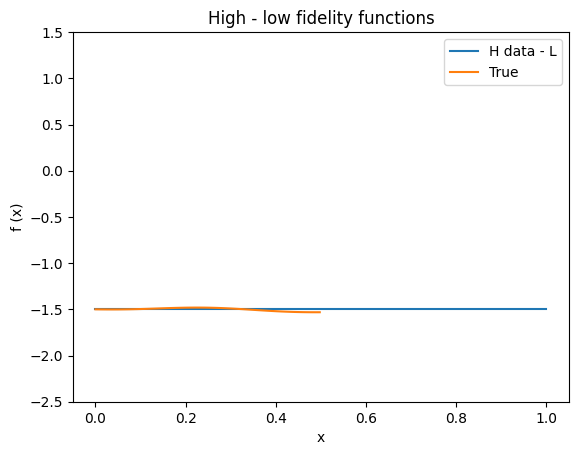

In [13]:
ypredict_h_from_l = model.predict(x_train_h)

## Plot the original functions

# plt.figure(figsize=(12, 8))
plt.plot(x_plot, y_plot_h - y_plot_l, "C0")
plt.plot(x_train_h, y_train_h[:, 0] - ypredict_h_from_l, "C1")
plt.ylabel("f (x)")
plt.xlabel("x")
plt.legend(["H data - L", "True"])
plt.title("High - low fidelity functions")
plt.ylim(-2.5, 1.5)

Ah this looks actually promising using easy functions

In [14]:
default_pysr_params = dict(
    populations=30,
    model_selection="best",
    # denoise=True,
)

# Learn equations
model_mf = PySRRegressor(
    niterations=30,
    binary_operators=["+", "*", "-"],
    unary_operators=["cos", "exp", "sin", "square", "cube", "log"],
    **default_pysr_params,
)

# The difference between high and low fidelity data is the target
y_diff = y_train_h[:, 0] - ypredict_h_from_l

model_mf.fit(x_train_h, y_diff)

/Users/jibanmac/Documents/conda/emu-3.9/lib/python3.9/site-packages/pysr/sr.py:2582: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/Users/jibanmac/Documents/conda/emu-3.9/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
[ Info: Started!


PySRRegressor.equations_ = [
	    pick     score                                           equation  \
	0         0.000000                                         0.18274808   
	1         9.286986                                   cube(-1.1450675)   
	2         0.466474                    -1.4889518 - square(square(x0))   
	3         0.133492                -1.4913027 - cube(-0.12151809 + x0)   
	4         0.714595              log(sin(1.7493012 - x0)) + -1.4882752   
	5         0.000058         sin(log(sin(1.7493012 - x0))) + -1.4882752   
	6         0.150102  ((x0 * (x0 - 0.38746285)) * -0.6431007) + -1.5...   
	7         0.032913  -1.5081773 + ((x0 * (sin(x0) - 0.36736175)) * ...   
	8         0.021791  (-1.1891658 - cos(square(cos(sin(x0 + -0.19505...   
	9         0.046570  (-1.1891658 - cos(square(cos(sin(sin(x0 + -0.1...   
	10        0.026140  (-1.1891658 - cos(square(cos(sin(sin(sin(x0 + ...   
	11        0.011679  0.858572 * (-1.1891658 - cos(square(cos(sin(si...   
	12        0.068301  -1.5081773 + (((x0 - 0.36736175) * sin(x0)) * ...   
	13        0.330962  -1.5081773 + ((x0 * (x0 - 0.36736175)) * (x0 -...   
	14  >>>>  0.597054  -1.5081773 + (cube(cube(sin((-0.7162779 * x0) ...   
	
	        loss  complexity  
	0   2.836579           1  
	1   0.000263           2  
	2   0.000065           5  
	3   0.000057           6  
	4   0.000028           7  
	5   0.000028           8  
	6   0.000024           9  
	7   0.000023          10  
	8   0.000023          11  
	9   0.000022          12  
	10  0.000021          13  
	11  0.000021          14  
	12  0.000019          15  
	13  0.000014          16  
	14  0.000008          17  
]

In [15]:
model_mf.sympy()

x0*(x0 - 1*0.36736175)*sin(-0.7162779*x0 - exp(x0))**9 - 1.5081773

In [16]:
model_mf.sympy(1) # The second simplest model

-1.50138912321353

In [17]:
ypredict = model_mf.predict(x_plot)
ypredict_simpler = model_mf.predict(x_plot, 1)

y_diff_true = y_plot_h - y_plot_l

print("Default selection MSE:", np.power(ypredict - y_diff_true, 2).mean())
print("Manual selection MSE for index 2:", np.power(ypredict_simpler - y_diff_true, 2).mean())

/Users/jibanmac/Documents/conda/emu-3.9/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/jibanmac/Documents/conda/emu-3.9/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Default selection MSE: 0.0002958068695292114
Manual selection MSE for index 2: 1.9296633023676576e-06


## Test the multi-fidelity output

In [18]:
def multi_fidelity(x, complexity=1):
    """
    Multi-fidelity model that predicts the high-fidelity function.
    """
    return model.predict(x) + model_mf.predict(x, complexity)

In [19]:
y_predict_mf = multi_fidelity(x_plot, 1)

/Users/jibanmac/Documents/conda/emu-3.9/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/jibanmac/Documents/conda/emu-3.9/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Text(0.5, 1.0, 'High fidelity function')

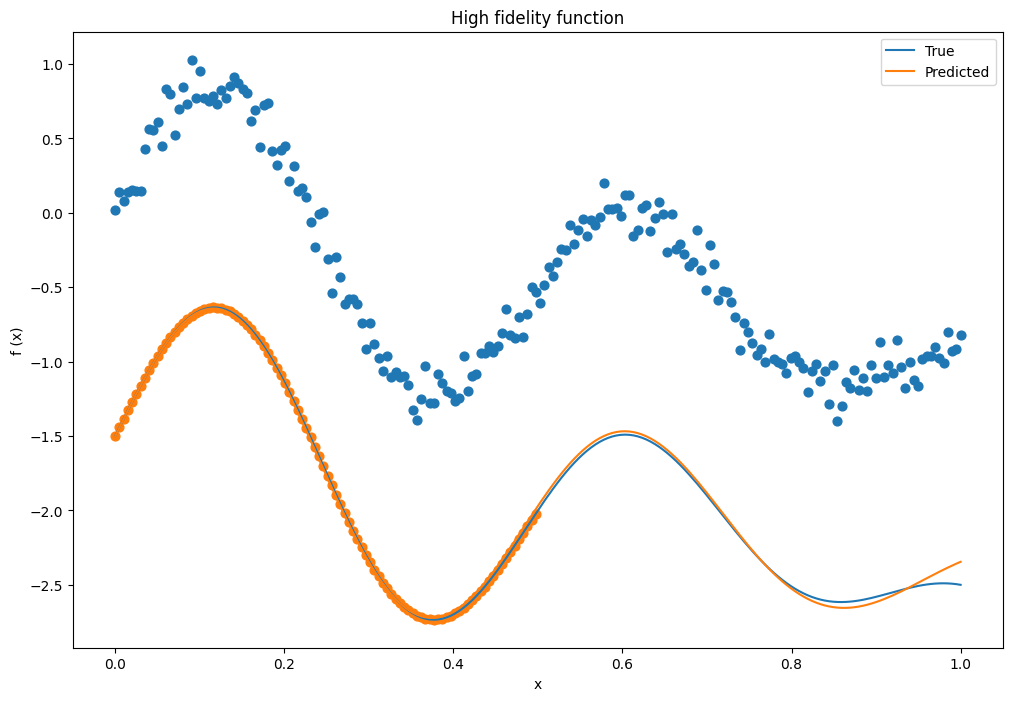

In [20]:
plt.figure(figsize=(12, 8))
plt.plot(x_plot, y_plot_h, "C0")
plt.plot(x_plot, y_predict_mf, "C1")
plt.scatter(x_train_l, y_train_l, color="C0", s=40)
plt.scatter(x_train_h, y_train_h, color="C1", s=40)
plt.ylabel("f (x)")
plt.xlabel("x")
plt.legend(["True", "Predicted"])
plt.title("High fidelity function")


## A wrapper to do SR for multiple levels

In [21]:
class MultiFidelitySRegressor:
    """
    Multi-fidelity surrogate model that predicts the high-fidelity function.

    Parameters
    ----------
    model : PySRRegressor
        Low-fidelity model.
    model_mf : PySRRegressor
        Multi-fidelity model.
    complexity : int
        Complexity of the multi-fidelity model.
    """
    def __init__(self, model, model_mf, complexity=1):
        self.model = model
        self.model_mf = model_mf
        self.complexity = complexity

    def fit(self, x_l, y_l, x_h, y_h):
        """
        Fit the multi-fidelity model.

        Parameters
        ----------
        x_l : array-like
            Low-fidelity input data.
        y_l : array-like
            Low-fidelity target data.
        x_h : array-like
            High-fidelity input data.
        y_h : array-like
            High-fidelity target data.
        """
        # train LF model
        self.model.fit(x_l, y_l)
        # Predict LF model on HF input data
        f_l = self.model.predict(x_h)

        # Stack the LF model predictions with the HF input data
        _x_h = np.hstack([x_h, f_l[:, None]])

        self.model_mf.fit(_x_h, y_h)

    def predict(self, x):
        """
        Predict the high-fidelity function.
        """
        f_l = self.model.predict(x)
        _x = np.hstack([x, f_l[:, None]])
        return self.model_mf.predict(_x, self.complexity)

    def sympy(self):
        return self.model.sympy(), self.model_mf.sympy(self.complexity)

    def __call__(self, x):
        return self.predict(x)

    def __repr__(self):
        return f"MultiFidelitySRegressor(model={self.model}, model_mf={self.model_mf}, complexity={self.complexity})"

/Users/jibanmac/Documents/conda/emu-3.9/lib/python3.9/site-packages/pysr/sr.py:2582: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/Users/jibanmac/Documents/conda/emu-3.9/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
[ Info: Started!
/Users/jibanmac/Documents/conda/emu-3.9/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/jibanmac/Documents/conda/emu-3.9/lib/python3.9/site-packages/pysr/sr.py:2582: UserWarning: Note: it looks like you

Text(0.5, 1.0, 'High fidelity function')

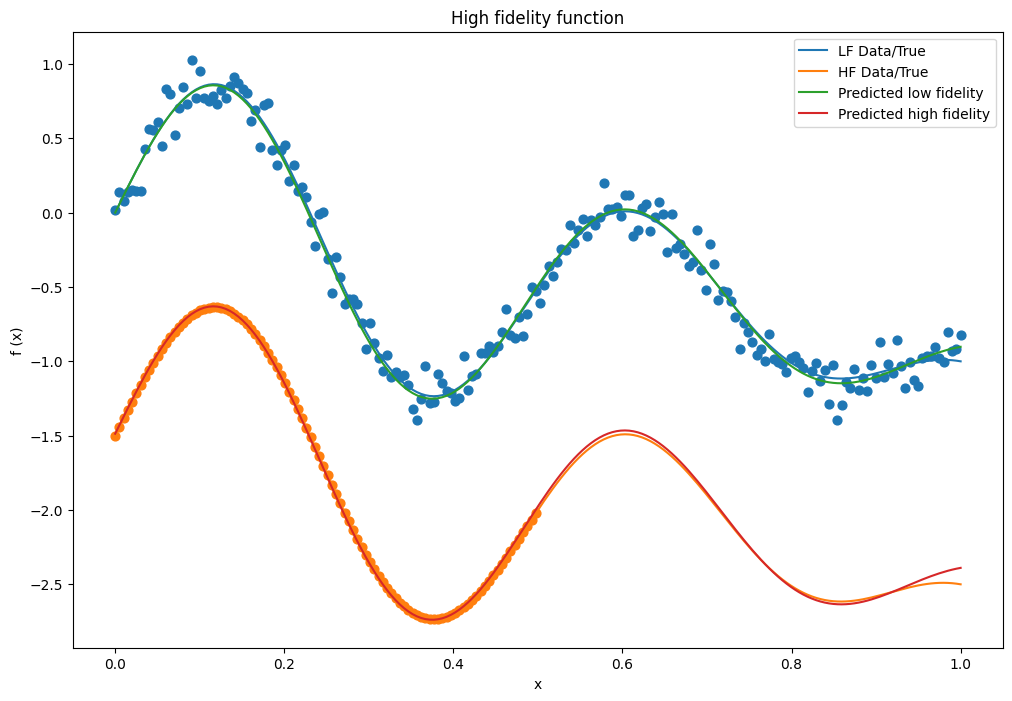

In [25]:
# Example usage
default_pysr_params = dict(
    populations=30,
    model_selection="best",
    denoise=True,
)

model = PySRRegressor(
    niterations=30,
    binary_operators=["+", "*", "-"],
    unary_operators=["cos", "exp", "sin", "square", "log"],
    **default_pysr_params,
)

# Example usage
# The score model selection works better for resolution correction
default_pysr_params = dict(
    populations=30,
    model_selection="score",
    denoise=True,
)

model_mf = PySRRegressor(
    niterations=30,
    binary_operators=["+", "*", "-"],
    unary_operators=["cos", "exp", "sin", "square", "log"],
    **default_pysr_params,
)

# Fit the multi-fidelity model
model_mf_s = MultiFidelitySRegressor(model, model_mf, complexity=None)

model_mf_s.fit(x_train_l, y_train_l[:, 0], x_train_h, y_train_h[:, 0])

# Predict the high-fidelity function
y_predict_mf = model_mf_s(x_plot)
# predict the low-fidelity function
y_predict_l = model_mf_s.model.predict(x_plot)

plt.figure(figsize=(12, 8))
plt.plot(x_plot, y_plot_l, "C0")
plt.plot(x_plot, y_plot_h, "C1")
plt.plot(x_plot, y_predict_l, "C2")
plt.plot(x_plot, y_predict_mf, "C3")
plt.scatter(x_train_l, y_train_l, color="C0", s=40)
plt.scatter(x_train_h, y_train_h, color="C1", s=40)
plt.ylabel("f (x)")
plt.xlabel("x")
plt.legend(["LF Data/True", "HF Data/True", "Predicted low fidelity", "Predicted high fidelity"])
plt.title("High fidelity function")


In [26]:
model_mf_s.sympy()[0]

-0.07016529*x0 - sin(x0) + sin(12.633782*x0)*cos(-1.4326541*x0)

In [27]:
model_mf_s.sympy()[1]

x1 - 1*1.4869816